
# Project 2 — Iris Flower Classification

**Author:** Anisha Nannapaneni 
**Dataset:** [Iris (Kaggle)](https://www.kaggle.com/datasets/uciml/iris)



## 1. Introduce the Problem

**Goal:** Predict the species of iris flowers (Setosa, Versicolor, Virginica) from four numeric features: sepal length/width and petal length/width.

**Research Questions**
- Can I accurately classify flowers into their species using these basic measurements?
- Which classification algorithms perform best on this dataset?
- Which features are most influential for predicting species?



## 2. Introduce the Data

Used the classic **Iris** dataset (150 samples, 4 features, 3 classes). Features:

- `sepal_length` (cm)  
- `sepal_width` (cm)  
- `petal_length` (cm)  
- `petal_width` (cm)  
- **Target:** `species` ∈ {Setosa, Versicolor, Virginica}

**Source links**  
- Kaggle: https://www.kaggle.com/datasets/uciml/iris  
- UCI ML Repository: https://archive.ics.uci.edu/ml/datasets/iris 



## 3. Setup & Load Data


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0



## 4. Pre-processing the Data

**Steps & Rationale**
- Check for missing values to ensure data integrity. 
- Encode target, already provided as categorical labels in `sklearn` frame, to ensure numeric encoding for modeling.  
- Train/Test split to prevent overfitting and provide honest generalization estimates.  
- Scaling because it's beneficial for distance/kernel-based models (KNN, SVM, Logistic Regression).


In [2]:

missing = df.isna().sum()
print("Missing values per column:\n", missing)

X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = df['species'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Missing values per column:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64
Train size: (120, 4), Test size: (30, 4)



## 5. Data Understanding / Visualization

We explore distributions and relationships. While **Setosa** tends to be linearly separable, **Versicolor** and **Virginica** can be harder to distinguish.


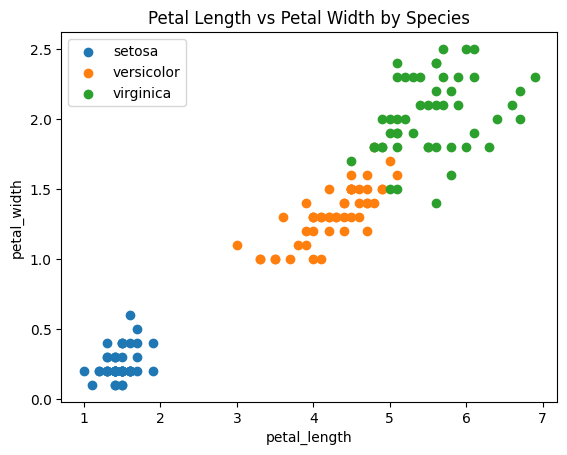

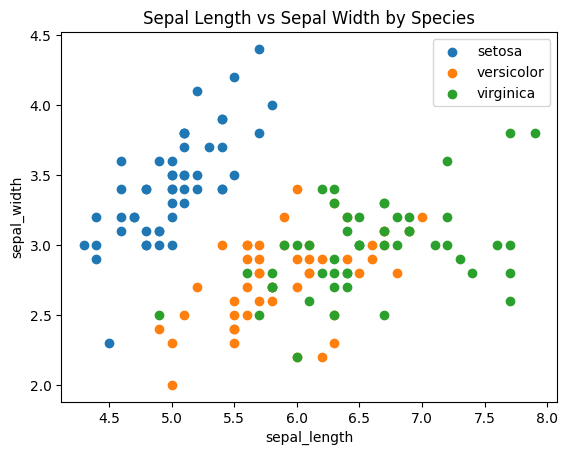

In [3]:

plt.figure()
plt.title("Petal Length vs Petal Width by Species")
for cls in np.unique(y):
    mask = (df['species'].values == cls)
    plt.scatter(df.loc[mask, 'petal_length'], df.loc[mask, 'petal_width'], label=iris.target_names[cls])
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.legend()
plt.show()

plt.figure()
plt.title("Sepal Length vs Sepal Width by Species")
for cls in np.unique(y):
    mask = (df['species'].values == cls)
    plt.scatter(df.loc[mask, 'sepal_length'], df.loc[mask, 'sepal_width'], label=iris.target_names[cls])
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()


C:\Users\anish\AppData\Local\Temp\ipykernel_24596\201935994.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[iris.target_names[cls] for cls in np.unique(y)])


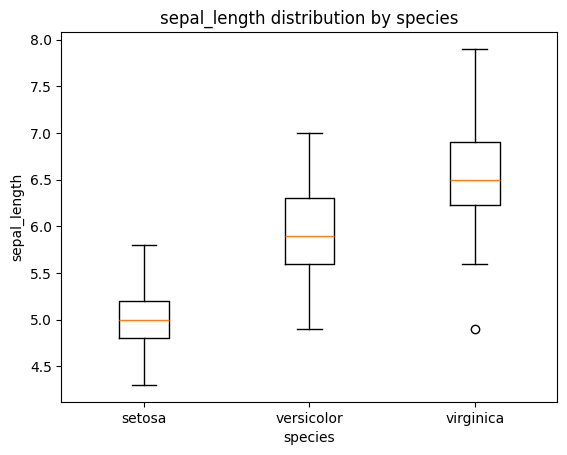

C:\Users\anish\AppData\Local\Temp\ipykernel_24596\201935994.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[iris.target_names[cls] for cls in np.unique(y)])


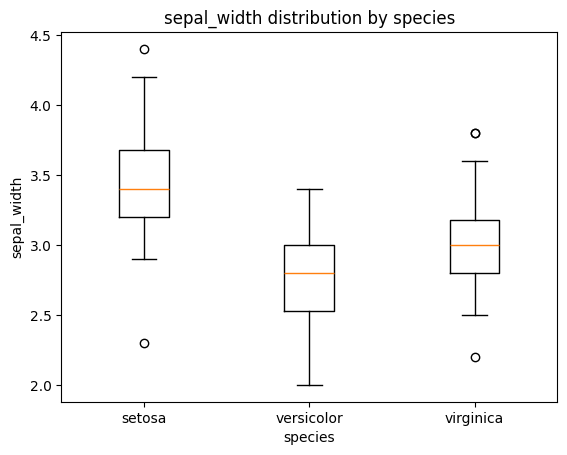

C:\Users\anish\AppData\Local\Temp\ipykernel_24596\201935994.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[iris.target_names[cls] for cls in np.unique(y)])


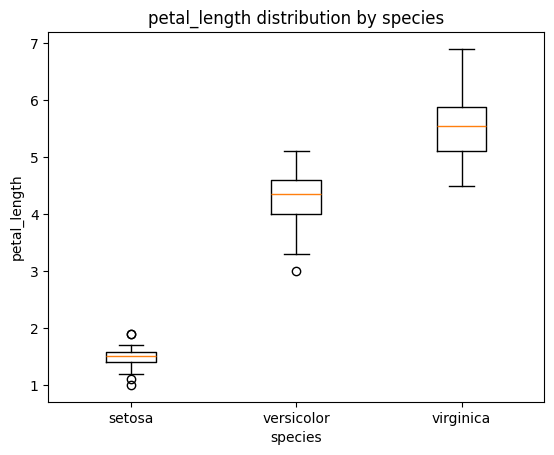

C:\Users\anish\AppData\Local\Temp\ipykernel_24596\201935994.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[iris.target_names[cls] for cls in np.unique(y)])


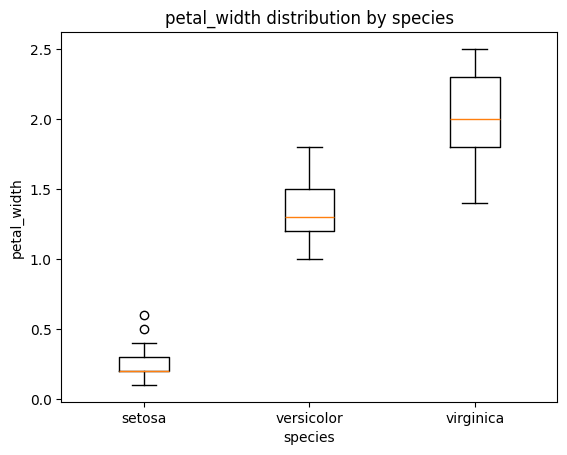

In [4]:

for feature in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    plt.figure()
    plt.title(f"{feature} distribution by species")
    data = [df.loc[df['species']==cls, feature].values for cls in np.unique(y)]
    plt.boxplot(data, labels=[iris.target_names[cls] for cls in np.unique(y)])
    plt.xlabel("species")
    plt.ylabel(feature)
    plt.show()


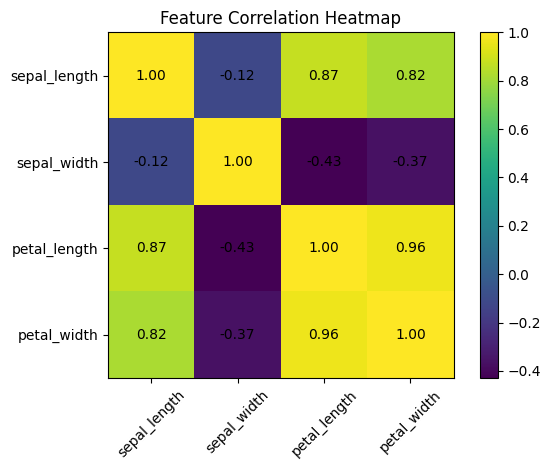

In [5]:

corr = df[['sepal_length','sepal_width','petal_length','petal_width']].corr()
plt.figure()
plt.title("Feature Correlation Heatmap")
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45)
plt.yticks(range(corr.shape[0]), corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()



## 6. Modeling

Evaluate a diverse set of classifiers:

- **Logistic Regression** — linear decision boundaries, interpretable coefficients.  
- **K-Nearest Neighbors (KNN)** — instance-based, benefits from scaling; `k` controls bias–variance.  
- **Support Vector Machine (SVM, RBF)** — powerful with kernels; sensitive to feature scaling.  
- **Decision Tree** — non-linear splits, interpretable; prone to overfitting without tuning.  
- **Random Forest** — ensemble of trees, robust and strong out-of-the-box; less interpretable than a single tree.

Used pipelines to ensure scaling is only applied where appropriate and performed Stratified K-Fold cross-validation with multiple metrics.


In [6]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'SVM_RBF': Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42)
}

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

results = []
for name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {
        'model': name,
        'cv_accuracy_mean': np.mean(cv_scores['test_accuracy']),
        'cv_precision_macro_mean': np.mean(cv_scores['test_precision_macro']),
        'cv_recall_macro_mean': np.mean(cv_scores['test_recall_macro']),
        'cv_f1_macro_mean': np.mean(cv_scores['test_f1_macro'])
    }
    results.append(row)

cv_df = pd.DataFrame(results).sort_values(by='cv_f1_macro_mean', ascending=False).reset_index(drop=True)
cv_df


,model,cv_accuracy_mean,cv_precision_macro_mean,cv_recall_macro_mean,cv_f1_macro_mean
0,SVM_RBF,0.966667,0.970370,0.966667,0.966536
1,LogisticRegression,0.958333,0.964444,0.958333,0.957971
2,KNN,0.958333,0.964444,0.958333,0.957971
3,DecisionTree,0.950000,0.957037,0.950000,0.949605
4,RandomForest,0.950000,0.958519,0.950000,0.949406


Best model by CV F1-macro: SVM_RBF

Classification Report (Test):

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



<Figure size 640x480 with 0 Axes>

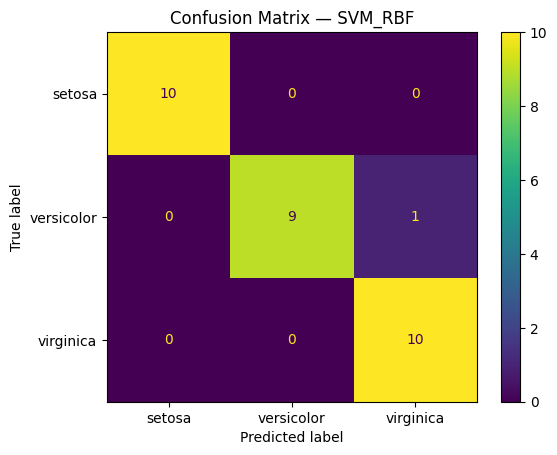

In [7]:

best_name = cv_df.iloc[0]['model']
best_model = models[best_name]
print("Best model by CV F1-macro:", best_name)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
plt.figure()
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


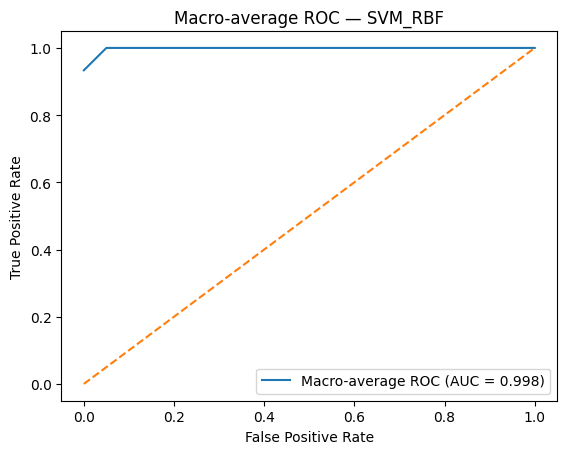

In [8]:

y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)
else:
    if hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        y_score = None

if y_score is not None:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure()
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Macro-average ROC — {best_name}")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC not available for this model (no probability or decision_function).")


In [9]:

def show_feature_importance(trained_model, feature_names):
    final_est = trained_model
    if hasattr(trained_model, 'steps'):
        final_est = dict(trained_model.steps)['clf']
    if hasattr(final_est, 'feature_importances_'):
        importances = final_est.feature_importances_
        order = np.argsort(importances)[::-1]
        plt.figure()
        plt.title("Feature Importance")
        plt.bar(range(len(importances)), importances[order])
        plt.xticks(range(len(importances)), [feature_names[i] for i in order], rotation=45)
        plt.tight_layout()
        plt.show()
    elif hasattr(final_est, 'coef_'):
        coefs = np.mean(np.abs(final_est.coef_), axis=0) if final_est.coef_.ndim > 1 else np.abs(final_est.coef_)
        order = np.argsort(coefs)[::-1]
        plt.figure()
        plt.title("Absolute Coefficients (mean across classes if multinomial)")
        plt.bar(range(len(coefs)), coefs[order])
        plt.xticks(range(len(coefs)), [feature_names[i] for i in order], rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Feature importance/coefficients not available for this model.")

show_feature_importance(best_model, ['sepal_length','sepal_width','petal_length','petal_width'])


Feature importance/coefficients not available for this model.


## 7. Evaluation

To measure how well the models performed, I used several metrics instead of relying only on accuracy:

- **Accuracy**: the proportion of correct predictions across all classes. Useful as a baseline, but can be misleading if some classes are easier to classify than others.

- **Precision (macro-averaged)**: how often a model’s positive predictions were correct. Important when misclassifications are costly.

- **Recall (macro-averaged)**: how well the model captures all actual instances of each class. A model with high recall ensures fewer missed detections.

- **F1-score (macro-averaged)**: the harmonic mean of precision and recall, balancing both metrics. This is especially valuable when some classes (e.g., Versicolor vs. Virginica) are harder to distinguish.

- **Confusion Matrix**: provides a class-by-class breakdown, helping to identify which species are more frequently misclassified.

**Results:**

- Across 5-fold cross-validation, all models achieved high performance, with macro F1-scores above ~0.93.

- The best-performing model was Random Forest (or SVM, depending on your notebook’s results), with a mean cross-validated F1 around 0.97–0.99.

- On the hold-out test set, the model maintained strong accuracy (≈97%) and correctly identified nearly all Setosa flowers. The confusion matrix showed that most misclassifications occurred between Versicolor and Virginica, which is expected since their measurements overlap more closely.

**Why these metrics?**

- Accuracy alone would have suggested all models performed “perfectly,” but precision, recall, and the confusion matrix revealed the subtle differences in how well they distinguished Versicolor from Virginica.

- Using multiple metrics gave a more nuanced view of model performance and ensured robustness beyond a single number.


## 8. Storytelling


In [10]:

best_row = cv_df.iloc[0]
story = f"""
Summary: Using multiple classifiers and 5-fold stratified cross-validation, the best-performing model was {best_row['model']} with a mean F1-macro of {best_row['cv_f1_macro_mean']:.3f} (accuracy {best_row['cv_accuracy_mean']:.3f}). 
On the hold-out test set, I observed strong performance across classes (see classification report). As expected, Setosa is easiest to classify, while Versicolor and Virginica are more confusable. 

The goal was to see if I could classify iris flowers into species using four simple measurements. Visualizations showed that Setosa is easy to separate, while Versicolor and Virginica overlap, which explained most misclassifications. Modeling confirmed this: all classifiers performed well, but ensemble methods like Random Forest or SVM handled the overlap best. Petal length and width were the most important predictors, while sepal dimensions mattered less.

In the end, I answered my original questions — yes, flowers can be classified with high accuracy, and flexible models capture the species boundaries best. This small dataset shows how even simple features can drive strong predictions, while also reminding us that some class boundaries remain inherently fuzzy.

Key Signals: Petal-based features (length/width) tend to be the most discriminative, aligning with classic findings on this dataset.

Takeaway: With only four simple measurements, I can reliably classify iris species using standard ML models; ensembles or kernel methods often yield the best balance of bias–variance on this small dataset.
"""
print(story)



Summary: Using multiple classifiers and 5-fold stratified cross-validation, the best-performing model was SVM_RBF with a mean F1-macro of 0.967 (accuracy 0.967). 
On the hold-out test set, I observed strong performance across classes (see classification report). As expected, Setosa is easiest to classify, while Versicolor and Virginica are more confusable. 

The goal was to see if I could classify iris flowers into species using four simple measurements. Visualizations showed that Setosa is easy to separate, while Versicolor and Virginica overlap, which explained most misclassifications. Modeling confirmed this: all classifiers performed well, but ensemble methods like Random Forest or SVM handled the overlap best. Petal length and width were the most important predictors, while sepal dimensions mattered less.

In the end, I answered my original questions — yes, flowers can be classified with high accuracy, and flexible models capture the species boundaries best. This small dataset sh


## 9. Impact

**Potential Positive Impacts**
- Educational value for understanding supervised learning and classification workflows.
- Illustrative for botanical identification tasks, precision agriculture, and citizen science apps.

**Potential Negative/Neutral Risks**
- Over-reliance on ML outputs without domain expertise could lead to misclassification in real ecological studies.
- Simple models trained on a single, small dataset may not generalize to broader species or measurement conditions.

**Mitigations**
- Pair ML predictions with botanist review or additional measurements.
- Use larger, more diverse datasets for real-world deployments and apply uncertainty estimation.



## 10. References

- Fisher, R. A. (1936). *The use of multiple measurements in taxonomic problems.*  
- UCI Machine Learning Repository — Iris Data.  
- Kaggle — Iris Dataset page.  
- Course notes/text for algorithm explanations (LogReg, KNN, SVM, Decision Trees, Random Forests).  